### Initialization

#### Packages

In [1]:
from IPython.display import display, Math, Latex 

from collections import defaultdict

#Network Stuff 
import networkx as nx
import igraph as ig 
from igraph import Graph
import markov_clustering as mc
from networkx.algorithms import community
from community import community_louvain
import random
import powerlaw 



# Gprofiler
from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)



# Standard 
import pandas as pd 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pickle 
import math


%matplotlib inline 
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 32}

plt.rc('font', **font)


#### Graph Processing

In [2]:
## Loading the graph 
G = nx.read_weighted_edgelist("C:\\Users\\yuanl\\OneDrive\\Documents\\Professional\\Projects\\MATH3888 - Biological Modelling\\Data\\4932.protein.links.v12.0.txt",comments="#",nodetype=str)

In [3]:
## Performing the random edge removals 
threshold_score = 500
for edge in G.edges: 
    weight = list(G.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] < threshold_score):
        G.remove_edge(edge[0],edge[1])


## Removing weights
for node, edges in nx.to_dict_of_dicts(G).items():
    for edge, attrs in edges.items():
        attrs.pop('weight', None)


In [4]:
# These are the important connections that we know SGS1 connects to 
related_proteins = ['YMR190C','YNL088W','YLR234W','YPL024W','YMR167W' ]

# Key assumption: Largest connected subgraph
largest_cc = max(nx.connected_components(G) , key=len) 

Gsub= G.subgraph(largest_cc) 
#print(Gsub.nodes())



#### Functions

In [5]:
#Functions 
def graph_description(graph): 
    #### Info
    print('Number of nodes of G:', graph.number_of_nodes())
    print('Number of edges of G:', graph.number_of_edges())
    print('Degree of SGS1 node:', graph.degree('4932.YMR190C'))
    print('Neighbours of SGS1 node:', list(graph.neighbors('4932.YMR190C'))[:5]) #up to 5? 
    print('Is the full network connected?',nx.connected.is_connected(graph))
    print('How many connected subgraphs are there?',nx.connected.number_connected_components(graph))

    deg = list(graph.degree()[node] for node in list(G.nodes()))
    deg = np.sort(deg)[::-1]
    degSGS1 =  graph.degree('4932.YMR190C')
    plt.figure() 
    #Bar 
    #plot = plt.bar(range(len(deg)), deg, color='blue')
    #plot[degSGS1].set_color('red') 
    #Hist 
    n, bins, patch = plt.hist(deg, bins=range(min(deg), max(deg) + 2), edgecolor = 'black', density=True, color = 'black') #specify bins please
    # Highlight the bar that contains the specific node's degree
    for patches, left_edge in zip(patch, bins[:-1]):
        if left_edge <= degSGS1 < left_edge + (bins[1] - bins[0]):
            patches.set_facecolor('red')  # Change color to red for the highlight degree
    plt.grid(True) 
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.xlabel('Degree', fontsize = 11) 
    plt.ylabel('Frequency', fontsize = 11)
    plt.title('Degree Distribution of Full PPI Network', fontsize = 11)
    plt.show() 

    
    ##### NEED TO MAKE SAMPLING LATER 
    # sample_size = size 
    ## Edge subsets of size N of the PPI network which still contains nodes 
    #Make a copy of the graph 
    #Take a random set of edges of size N of the graph 
    #Restrict the graph to that 
    #Then store it? 

    # #get the largest component
    # largest_comp = max(nx.connected_components(G),key=len)
    # G1 = G.subgraph(largest_comp) #pruned network

    # print('number of nodes of largest connected subgraph of G:',G1.number_of_nodes())
    # print('number of edges of largest connected subgraph of G:',G1.number_of_edges())


def mixing_param(graph, partitiongraph): 
    kext = {node: 0 for node in graph.nodes()}
    ktot = sum(degree for _, degree in graph.degree())
    for node in graph.nodes(): 
        community_label = partitiongraph[node]
        for neighbour in graph.neighbors(node): 
            if partitiongraph[neighbour] != community_label:
                kext[node] += 1
    mp = sum(kext.values())/ktot 
    return mp 

####################
# COMMUNITY FINDING ALGORITHMS #
####################
def mcl(graph, inflation_parameter):
    ## Converting to array
    matrix = nx.to_numpy_array(graph)
    node_list = list(graph.nodes)

    ## Get rid of the bloody nodes 
    for i, node in enumerate(node_list):
        node_list[i] = node.split(".")[1]


    result = mc.run_mcl(matrix,inflation = inflation_parameter)
    clusters = mc.get_clusters(result)

    #relabelling node names 
    for i in range(0,len(clusters)):
        clu_list = list(clusters[i])
        
        for j in range(0,len(clu_list)):
            name = node_list[clu_list[j]]
            clu_list[j] = name
        clusters[i] = tuple(clu_list)

    return inflation_parameter, result, clusters   







##### EDIT THIS LATER SO THAT IT INCORPORATES THE SAMPLES I.E. INCORPORATE THE METHOD USING ROCKY 
### Main nassumption: order of G.nodes is the same order as all these other centrality measures and every node list in igraph 


def infomap(nxgraph): 

    ### MAKE SURE IT IS FROM NETWORKX 
    ### ADD SAMPLING LATER 
    iggraph = ig.Graph.from_networkx(nxgraph)
    communities = iggraph.community_infomap()
    #run_records = []

    #Algorithm

    # for i in range(trials):
    #     random_number_in_range = random.randint(0 , 2**(64)-1)  #Takes a random number
    #     Graph.set_random_number_generator(random_number_in_range) #set the seed 
    #     iter_communities = iggraph.community_infomap() 




    #Dictionary of communities and lists of nodes 
    nodeassignment = communities.membership 
    iggraph.vs["name"]  = list(nxgraph.nodes())
    
    nodenames = iggraph.vs["name"]

    for i, node in enumerate(nodenames):
        nodenames[i] = node.split(".")[1]


    commnum = max(value for _, value in enumerate(nodeassignment))+1
    commdict = {}

    for i in range(commnum): 
        commdict[i] = []

    for nodeint, cluster in enumerate(nodeassignment): 
        nodename = nodenames[nodeint]
        commdict[cluster].append(nodename) 

    
    #iggraph is the converted graph from nx, nodenames are an ordered list of names, nodeassignment is the assignment of each node to a community, communities is a list, commdict is a dictionary of a dictionary, and commnum is number
    return iggraph, nodenames, nodeassignment, communities, commdict, commnum





def community_limit(commdict, maxnode): 
    for commind, nodelist in commdict.items(): 
        if len(nodelist) < maxnode: 
            del commdict[commind]

            
####################
# CENTRALITY #
####################

# - for each type of measure, create a dictionary that is identified by the specific cluster created d
# - pick the top 10 highest nodes 
# - Then maybe feed this back into the loop and see how we can try to cluster based on centrality measures (DO WE ALSO HAVE TO OPTIMIZE THE COMMUNITY FINDING ALGO) 

            

def centrality_measures(iggraph, nodenames, nodeassignment):
    nodenamedict = {nodeind:nodename for nodeind, nodename in enumerate(nodenames)}


    c1 = iggraph.betweenness(directed=False)
    c2 = iggraph.edge_betweenness(directed=False)
    c3 = iggraph.closeness()
    c4 = iggraph.eigenvector_centrality(directed=False)
    c5 = iggraph.pagerank(directed=False)

    betweenness = {clusterind:{nodenamedict[nodeind]:c1[nodeind] for nodeind in range(len(nodeassignment)) if nodeassignment[nodeind] == clusterind} for clusterind in set(nodeassignment)}
    edge_betweenness = {clusterind:{nodenamedict[nodeind]:c2[nodeind] for nodeind in range(len(nodeassignment)) if nodeassignment[nodeind] == clusterind} for clusterind in set(nodeassignment)}
    closeness = {clusterind:{nodenamedict[nodeind]:c3[nodeind] for nodeind in range(len(nodeassignment)) if nodeassignment[nodeind] == clusterind} for clusterind in set(nodeassignment)}
    eigenvector = {clusterind:{nodenamedict[nodeind]:c4[nodeind] for nodeind in range(len(nodeassignment)) if nodeassignment[nodeind] == clusterind} for clusterind in set(nodeassignment)}
    pagerank = {clusterind:{nodenamedict[nodeind]:c5[nodeind] for nodeind in range(len(nodeassignment)) if nodeassignment[nodeind] == clusterind} for clusterind in set(nodeassignment)}

    #nodescoredict = {centraltype:{nodeindex:nodescore for nodeindex, nodescore in enumerate(nodescores)} for centraltype, nodescores in zip(centralitymeasures, nodescorelist)}
    

    return betweenness, edge_betweenness, closeness, eigenvector, pagerank 
    
    #print('The ranking of SGS1 using this centrality is', )

    #Ranking of SGS1 in these 

    #target node = '4932.YMR190C' 

def community_length_check(centralitydict, commdict, commnum):
    counter = 0 
    for i in range(commnum): 
        if len(centralitydict[i]) == len(commdict[i]): 
            counter += 1 
    if counter == commnum:
        print('All communities match in length') 
    else:  
        print('Yeah nah go back')

####################
# SIMILARITY #
####################
def similarity_of_clusterings(clusters1, name1, clusters2, name2):
    sim_list = []
    for i in range(0,len(clusters1)) :
        jaccardsim = []
        for j in range(0,len(clusters2)):
            set1 = set(clusters1[i])
            set2 = set(clusters2[j])
            intersection = set1.intersection(set2)  # |A ∩ B|
            union = set1.union(set2)  # |A ∪ B|
            # intersectioncounter = 0
            # for k in clusters1[i]:
            #     if k in clusters2[j]:
            #         intersectioncounter +=1
            # score = intersectioncounter/(len(clusters1[i])+len(clusters2[j]))
            if len(union) > 0:  # Avoid division by zero
                score = len(intersection) / len(union)
                if score > 0:
                    jaccardsim.append((f"{name2}{j} {len(clusters2[j])}:",score)) #first element can be str(name2)+str(j)+' '+str(len(clusters2[j]))+':'
        jaccardsim = sorted(jaccardsim, key = lambda x:x[1], reverse= True)
        jaccardsim.insert(0,f"{name1}{i} {len(clusters1[i])}:") #second element can bestr(str(name1)+str(i)+' '+str(len(clusters1[i]))+':'
        sim_list.append(jaccardsim)
    return sim_list

# return large communities above a threshold of nodes
def large_comm(cluster, threshold):
    large = []
    if isinstance(cluster, list):
        for item in cluster:
            if len(item)>=threshold:
                large.append(item)
    elif isinstance(cluster, dict):
        for item in cluster.values():
            if len(item)>=threshold:
                large.append(item)
    
    large = sorted(large, key = len, reverse = True)
    return large




#### Graph Details (including pruning)

Number of nodes of G: 6538
Number of edges of G: 190292
Degree of SGS1 node: 213
Neighbours of SGS1 node: ['4932.Q0160', '4932.YAL019W', '4932.YAR007C', '4932.YBL019W', '4932.YBL023C']
Is the full network connected? False
How many connected subgraphs are there? 375


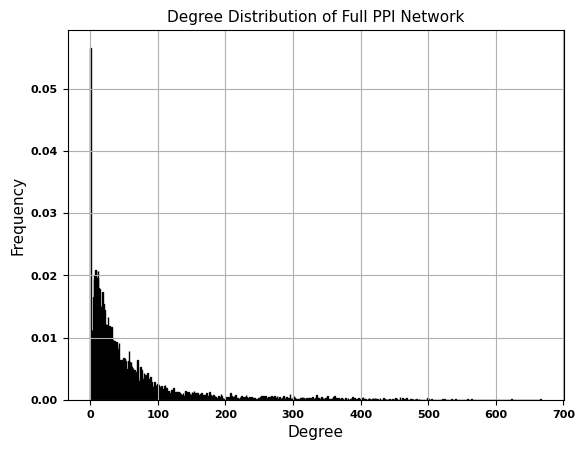

In [6]:
graph_description(G)


### Part 1: The Anchoring Process 

Infomap Parameters: 

markov_time : float, optional

- Scales link flow to change the cost of moving between modules.
- Higher values results in fewer modules.

variable_markov_time : bool, optional

- Increase Markov time locally to level out link flow. Reduces risk of
- overpartitioning sparse areas while keeping high resolution in dense areas.

variable_markov_damping : float, optional

- Damping parameter for variable Markov time, to scale with local effective
- degree (0) or local entropy (1).

### Community Size Distributions

In [7]:
# Markov Clustering 

### ACCORDING TO::::
# 1.4 is the inflation parameter that maximises modularity 
# This was found by manually searching through values ranging from 1.0, 2.0 with 0.1 step size

inflation_parameter = 1.4
markov_clustering = mcl(G, inflation_parameter)
clusters = markov_clustering[2]


Calculating best minimal value for power law fit


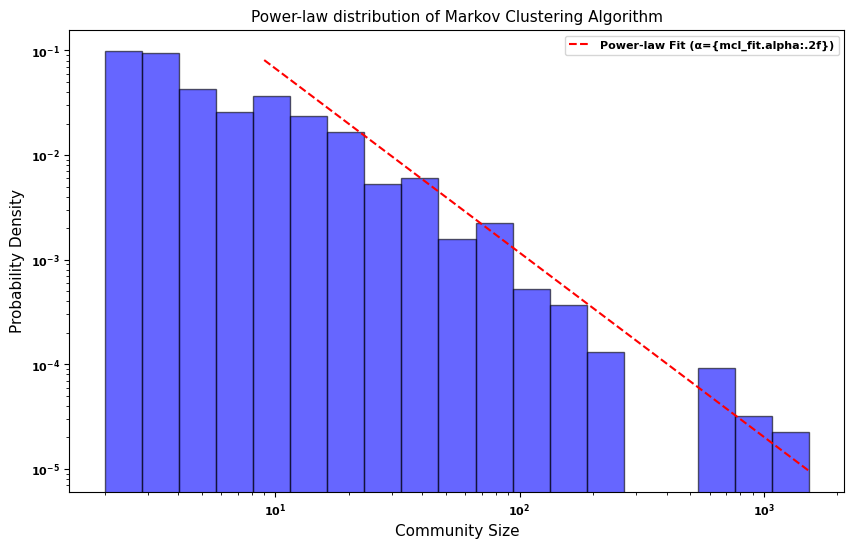

In [8]:
mclcommsize = [len(cluster) for cluster in clusters if len(cluster) > 1] #Alternatively, run the large_comm function and then just make a list of the length of clusters 

plt.figure(figsize=(10, 6))

# Plotting the histogram
plt.hist(mclcommsize, bins=np.logspace(np.log10(min(mclcommsize)), np.log10(max(mclcommsize)), 20), density=True, edgecolor = 'black', alpha=0.6, color='b') #maybe make the min 1



# Power law fitting 
mcl_fit = powerlaw.Fit(mclcommsize, discrete=True)
mcl_x = np.linspace(mcl_fit.xmin, max(mclcommsize), 100)  # Adjust x values to the range of the data
mcl_pdf = mcl_fit.power_law.pdf(mcl_x)  # Get the PDF for the fitted power-law
plt.plot(mcl_x, mcl_pdf, color='r', linestyle='--', label='Power-law Fit (α={mcl_fit.alpha:.2f})')


# Set logarithmic scale
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Community Size', fontsize = 11)
plt.ylabel('Probability Density', fontsize = 11)
plt.title('Power-law distribution of Markov Clustering Algorithm', fontsize = 11)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.legend(fontsize=8, loc='upper right')
plt.show()

In [9]:
def infomap_powerlaw(graph, trials):
    powerlawexp= [] 
    for i in range(trials): 

        # Run the infomap 
        g, nodenames, nodeassignment, communities, commdict, commnum = infomap(graph)
        commsize = [len(cluster) for cluster in commdict.values() if len(cluster) > 1] #Alternatively, run the large_comm function and then just make a list of the length of clusters 
        
        # Power Law Fitting
        fit = powerlaw.Fit(commsize, discrete=True)
        x = np.linspace(fit.xmin, max(commsize), 100)  # Adjust x values to the range of the data
        pdf = fit.power_law.pdf(x)  # Get the PDF for the fitted power-law

        # Get the powerlaw 
        powerlawexp.append(fit.alpha) 

    mcl_fit_values = np.full_like(powerlawexp, mcl_fit.alpha)


    
    #### Fit the final values: MAKE IT SO THAT AS IT GOES FURTHER AWAY FROM THE 1.76 VALUE, IT FADES OUT 
    plt.figure(figsize=(10, 6))
    plt.scatter(powerlawexp, mcl_fit_values, color='black', marker='o', linestyle='None')

    plt.xlabel('Infomap Power Law Exponent', fontsize = 11)
    plt.ylabel('MCL Power Law Exponent', fontsize = 11)
    plt.title('Change in the Power Law Exponent of Infomap', fontsize = 11)
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.xticks(np.arange(0, 4, 0.5))


    plt.show() 




    #### Fit the final graph
    plt.figure(figsize=(10, 6))
    # Plotting the histogram
    plt.hist(commsize, bins=np.logspace(np.log10(min(commsize)), np.log10(max(commsize)), 20), density=True, edgecolor = 'black', alpha=0.6, color='b',) #maybe make the min 1
    plt.plot(x, pdf, color='r', linestyle='--', label='Power-law Fit (α={fit.alpha:.2f})')
    # Set logarithmic scale
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Community Size', fontsize = 11)
    plt.ylabel('Probability Density', fontsize = 11)
    plt.title('Power-law distribution of Infomap', fontsize = 11)
    plt.tick_params(axis='both', which='major', labelsize=8)


    plt.legend(fontsize=8, loc='upper right')
    plt.show()




##### Observations 

# - If you use full graph that has edges removed on MCL, it is 1.76. The full graph for Infomap is 1.84, but the largest connected subgraph has 1.80. 
# - If you use connected subgraph on MCL, it does not change anything. But now the largest connected graph for infomap becomes 1.84 and fullgraph is 1.88
# - Maybe it is not about what you pick, but the range of values is because of the randomness i.e. largest observed is 2.06 

# - TIME TO PLOT THE TRIALSSSS


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


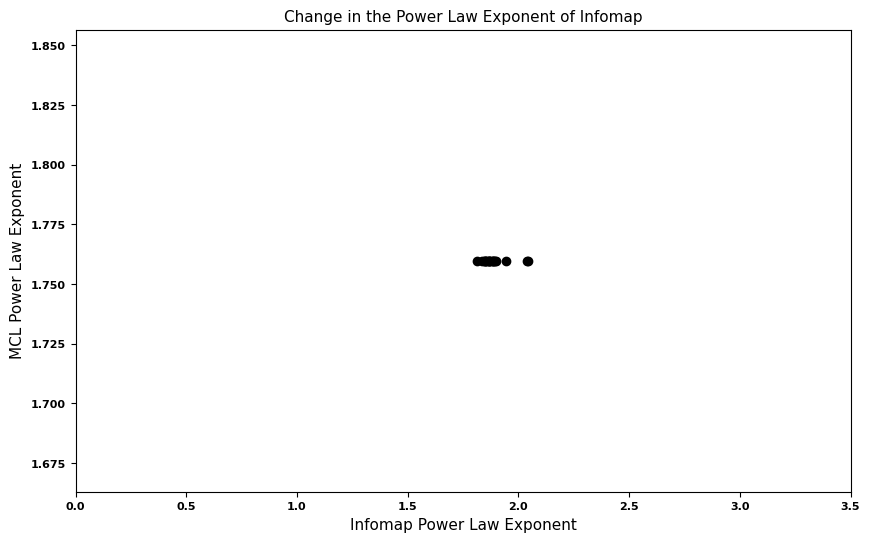

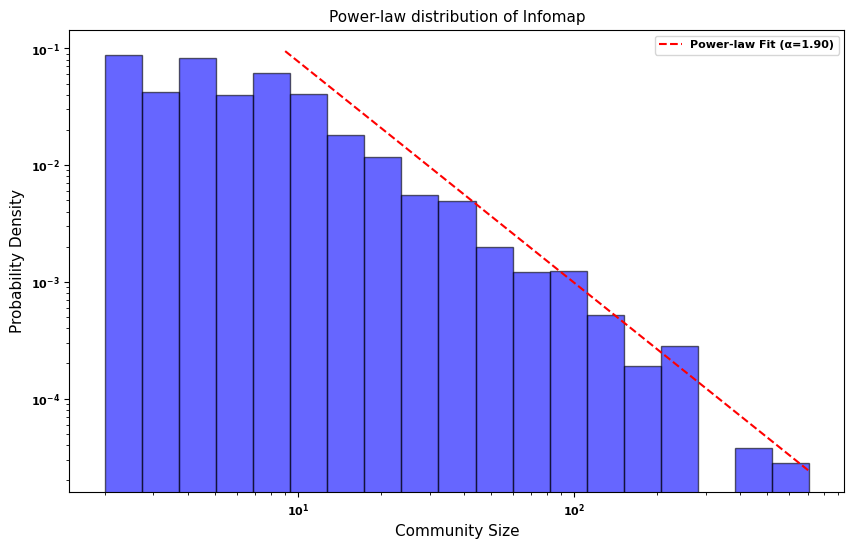

In [58]:
infomap_powerlaw(G, 10)

#### Similarity Measure

In [117]:
#Infomap
g, nodenames, nodeassignment, communities, commdict, commnum = infomap(G)

# for key in commdict:
#     print('The size of community #', list(commdict.keys())[key], 'is ',len(commdict[key]))

# nodetarg = next((key for key, value in enumerate(nodenames) if value == '4932.YMR190C'),None)

# print('The target protein SGS1 belongs to community #',nodeassignment[nodetarg])
# print('The size of community that SGS1 belongs to:', len(commdict[nodeassignment[nodetarg]]), 'nodes')

In [121]:
# Get rid of communities below a threshold and sort the clusters in descending order
mcl_clusterlist = large_comm(clusters, 30) 
info_clusterlist = large_comm(commdict, 30)

In [122]:

sim_ip_mc = similarity_of_clusterings(info_clusterlist,'ip', mcl_clusterlist,'mc')

for i in sim_ip_mc: 
    print(i[0], i[1])
    # if len(i) > 1: 
    #     print(i[0], i[1])
    # else:
    #     print("No similar communities with Infomap", i) 


ip0 713: ('mc2 722:', 0.8956406869220608)
ip1 434: ('mc0 1537:', 0.2554140127388535)
ip2 238: ('mc1 880:', 0.26613816534541335)
ip3 233: ('mc0 1537:', 0.14935064935064934)
ip4 213: ('mc4 213:', 0.8521739130434782)
ip5 212: ('mc1 880:', 0.2039691289966924)
ip6 193: ('mc1 880:', 0.21242937853107344)
ip7 166: ('mc3 598:', 0.2733333333333333)
ip8 144: ('mc1 880:', 0.159682899207248)
ip9 121: ('mc5 136:', 0.8489208633093526)
ip10 116: ('mc8 115:', 0.8629032258064516)
ip11 114: ('mc3 598:', 0.12836767036450078)
ip12 112: ('mc6 136:', 0.6756756756756757)
ip13 104: ('mc0 1537:', 0.056664520283322604)
ip14 98: ('mc7 123:', 0.7967479674796748)
ip15 93: ('mc0 1537:', 0.05025773195876289)
ip16 90: ('mc11 85:', 0.9230769230769231)
ip17 83: ('mc3 598:', 0.13689482470784642)
ip18 82: ('mc0 1537:', 0.05198180636777128)
ip19 74: ('mc0 1537:', 0.03667953667953668)
ip20 69: ('mc10 88:', 0.13768115942028986)
ip21 68: ('mc10 88:', 0.6956521739130435)
ip22 66: ('mc12 77:', 0.810126582278481)
ip23 55: ('mc14

In [ ]:
#### NEED TO COMPARE MITCH'S SIMILARITY WITH JACCARD? I.E. CREATE A GRAPH

#### Louvain and Mixing Parameter

In [7]:
#Louvain 
partitionLouvain = community_louvain.best_partition(G)
number_of_communities = max(partitionLouvain.values())+1 #We add one because the indexing starts at 0.
print('# of partitions for Louvain modularity =',number_of_communities)

# of partitions for Louvain modularity = 384


In [9]:
#Mixing parameter = sum of degree of each node that is connected to other communities/sum of the degrees of all nodes

print(mixing_param(G, partitionLouvain))
#print(mixing_param(G1, partitionLouvain1))


0.2765854581380195


### Centrality Measures

In [9]:
b, eb, cl, eig, page = centrality_measures(g, nodenames, nodeassignment)

In [18]:
#Probing the results 
nodetarg = next((key for key, value in enumerate(nodenames) if value == '4932.YMR190C'),None)
community_length_check(b, commdict, commnum)
#print('Ranking of SGS1 in each centrality measure', )

targetnode = '4932.YMR190C'
SGS1comm = nodeassignment[nodetarg] 

##Ranking of SGS1 in each centrality measure 
SGS1b = b[SGS1comm]#['4932.YMR190C'] #higher number means that it is a node that everyone has to pass through
SGS1eb = eb[SGS1comm]#['4932.YMR190C'] #same thing as node but now for edges connected to SGS1
SGS1cl = cl[SGS1comm]#['4932.YMR190C'] #near 0, more likely to be far away from others, and near 1 more closely 
SGS1eig = eig[SGS1comm]#['4932.YMR190C']
SGS1page = page[SGS1comm]#['4932.YMR190C']




All communities match in length
{'4932.YDR227W': 10304.606953656492, '4932.YGL113W': 39.51228157270217, '4932.YER041W': 899.3699881091106, '4932.YDR390C': 1208.656304854261, '4932.YMR224C': 18952.80819779064, '4932.YDL064W': 37491.32376474433, '4932.YGL058W': 19876.361810258994, '4932.YKL113C': 8181.610669164743, '4932.YGR258C': 4907.985766381634, '4932.YNL312W': 13506.939517385681, '4932.YOR033C': 14547.269300234067, '4932.YDR263C': 29984.429579305714, '4932.YDR369C': 8895.292616753804, '4932.YAR007C': 17498.19611471864, '4932.YDR092W': 4862.60040225383, '4932.YBR186W': 2988.0066374987427, '4932.YKL011C': 2873.140496316875, '4932.YOL063C': 300.9708427893578, '4932.YLR288C': 3189.5845520185267, '4932.YGL250W': 98.14234493156516, '4932.YMR190C': 25390.713576826613, '4932.YHR120W': 566.6807124938415, '4932.YIL082W': 3098.481814075636, '4932.YCR092C': 2377.3347994593673, '4932.YNL088W': 49236.563003731266, '4932.YBL088C': 3083.7090665095334, '4932.YOR330C': 22345.036720740194, '4932.YJR14

### Junk

In [11]:
help(g.betweenness)
help(g.edge_betweenness)
help(g.coseness)
help(g.pagerank)
help(g.eigenvector_centrality)
help(g.community_infomap)
help(g.community_infomap())
#Infomap has a trial

AttributeError: 'Graph' object has no attribute 'betweenness'

In [26]:
# PYTHON PACKAGE 
# im = Infomap(directed = False, markov_time = 0.09, variable_markov_time = False) #silent = True suppresses the outputs
# mapping = im.add_networkx_graph(G1) 
# im.run() 

# comm1 = im.getModules() 
# commdict = defaultdict(list) 
# {commdict[comm1[nodeint]].append(mapping[nodeint]) for nodeint in comm1}
# commdict = dict(commdict)
# commdict = dict(sorted(commdict.items()))

# #Alternatively, an ordered dictionary according to communities: 
# # commdict1 = {}
# # commnum = max(communities.values())+1
# # for i in range(commnum):
# #     commdict1[i] = [] #create an empty list for each community

# # for nodeint, community in communities.items():
# #     nodename = mapping[nodeint] 
# #     commdict1[community].append(nodename)

# for key in commdict:
#     print('The size of community #', list(commdict.keys())[key-1], 'is ',len(commdict[key])) #Acquires the keys of community dictionary which is the specific community and prints the size 

# nodetarg = next((key for key, value in mapping.items() if value == '4932.YMR190C'),None)

# print('The target protein SGS1 belongs to community #',comm1[nodetarg])